# Credit Card Fraud Detection

## Contents

* [Introduction](#section1)
* [Importing libraries and files](#section2)
* [EDA](#section3)
 * [First look at the data](#section3.1)
 * [Description of features](#section3.2)
 * [Balance of class](#section3.3)
 * [Distribution of features](#section3.4)
 * skewdness
 * kurtosis
* [Preprocessing](#section4)
 * Detection of anomalies
* Models
* Feature Importance
* Conclusion


<a id='section1'></a>
## Introduction
 * Link to Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud
 * Essentially, fraudulent transactions are those, where the holder of the credit card is charged for items he did not purchase.

<a id='section2'></a>
## Importing libraries and files


In [19]:
import numpy as np
import pandas as pd
from tqdm import tqdm


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase
import seaborn as sns

from scipy.stats import kurtosis, skew
from sklearn.manifold import TSNE
from tqdm import tqdm

In [6]:
data = pd.read_csv('creditcard.csv')


<a id='section3'></a>
## EDA
Description of the data:
* shape
* data types
* Description of features
* balance of class
* Distribution of amount by target
* Distribution of amount by time? fraudulent transact close together?
* Distribution of v1-28 by target and maybe by binned amount
* skewness
* kurtosis


<a id='section3.1'></a>
### First look at the data


In [7]:
print('Shape of the data:\n{}'.format(data.shape))

print('\nData types:\n{}'.format(pd.unique(data.dtypes)))

print('\nNumber of missing values in the data:\n{}'.format(data.isna().sum().sum()))

Shape of the data:
(284807, 31)

Data types:
[dtype('float64') dtype('int64')]

Number of missing values in the data:
0


In [8]:
pd.DataFrame.round(data.describe(), decimals=3)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,...,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000,284807.000
mean,94813.860,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,...,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,88.350,0.002
std,47488.146,1.959,1.651,1.516,1.416,1.380,1.332,1.237,1.194,1.099,...,0.735,0.726,0.624,0.606,0.521,0.482,0.404,0.330,250.120,0.042
min,0.000,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,...,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000,0.000
25%,54201.500,-0.920,-0.599,-0.890,-0.849,-0.692,-0.768,-0.554,-0.209,-0.643,...,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.600,0.000
50%,84692.000,0.018,0.065,0.180,-0.020,-0.054,-0.274,0.040,0.022,-0.051,...,-0.029,0.007,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000,0.000
75%,139320.500,1.316,0.804,1.027,0.743,0.612,0.399,0.570,0.327,0.597,...,0.186,0.529,0.148,0.440,0.351,0.241,0.091,0.078,77.165,0.000
max,172792.000,2.455,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,...,27.203,10.503,22.528,4.585,7.520,3.517,31.612,33.848,25691.160,1.000


<a id='section3.2'></a>
### Description of features

Time 
- Number of seconds elapsed between this transaction and the first transaction in the dataset.

Amount
- Transaction Amount.

Class
- 1 for fraudulent transaction, 0 for non-fraudulent transaction.

V1 - V28
- Numerical input variables which are the principal components obtained with PCA transformation.


<a id='section3.3'></a>
### Balance of class


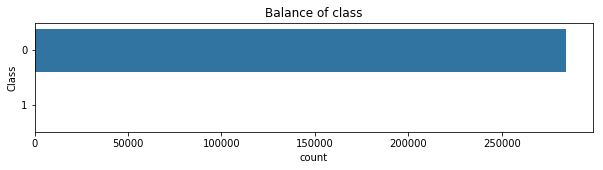

Number of fraudulent transactions in the data:
492
0.00173% of the transactions are fraudulent


In [9]:
fig = plt.figure(figsize=(10, 2))
plt.title('Balance of class')
ax = sns.countplot(y=data.Class)
plt.show()

print('Number of fraudulent transactions in the data:\n{}'.format(data['Class'].loc[data['Class'] == 1].count()))
print('{}% of the transactions are fraudulent'
      .format(round(data['Class'].loc[data['Class'] == 1].count()/data['Class'].count(), 5)))


The data set is highly unbalanced with 492 cases of fraud out of 284,807 transactions.
Besides the necessity of stratified sampling, Tom Fawcett recommends in his blog a number of steps which can be 
to handle the imbalance of classes.* The publishers of the data set recommend using
the area under the Precision-Recall Curve (AUPRC) as a measurement of accuracy.

*Source: https://www.svds.com/learning-imbalanced-classes


<a id='section3.4'></a>
### Distribution of features


In [10]:
data_nf = data.loc[data['Class'] == 0]
data_f = data.loc[data['Class'] == 1]


C:\Anaconda\envs\Py\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


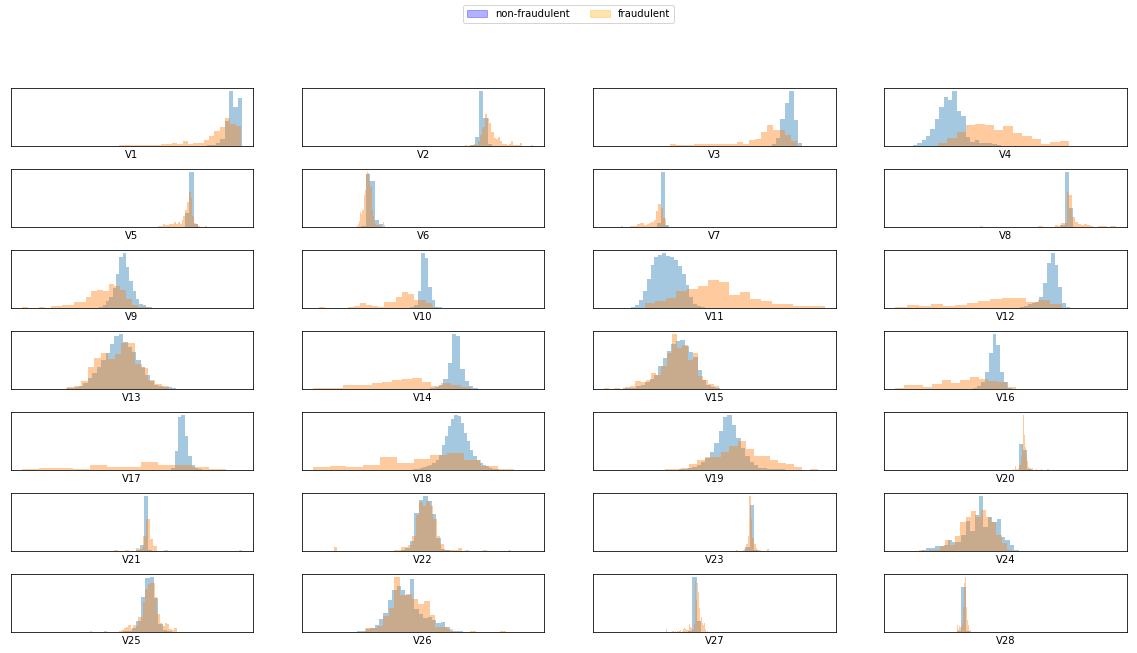

In [11]:
# Plotting distribution of features V1 to V28

def plt_var_dist():
    features = data.columns[1:29]
    fig, axes = plt.subplots(ncols=4, nrows=7, figsize=(20, 10))
    for ax, feature in  zip(axes.flatten(), features):
        sns.distplot(data_nf[feature], kde=False, norm_hist=True,label='non-fraudulent', ax=ax)
        sns.distplot(data_f[feature], kde=False, norm_hist=True,label='fraudulent', ax=ax)
        ax.set_xticks([])
        ax.set_yticks([])
    blue_patch = mpatches.Patch(color='blue', label='non-fraudulent', alpha=0.3)
    orange_patch = mpatches.Patch(color='orange', label='fraudulent', alpha=0.3)
    fig.legend(handles=[blue_patch, orange_patch], ncol=2, loc='upper center')
    fig.subplots_adjust(hspace=0.4)
    
    fig.show()
        
plt_var_dist()



Distribution of 'Time' feature


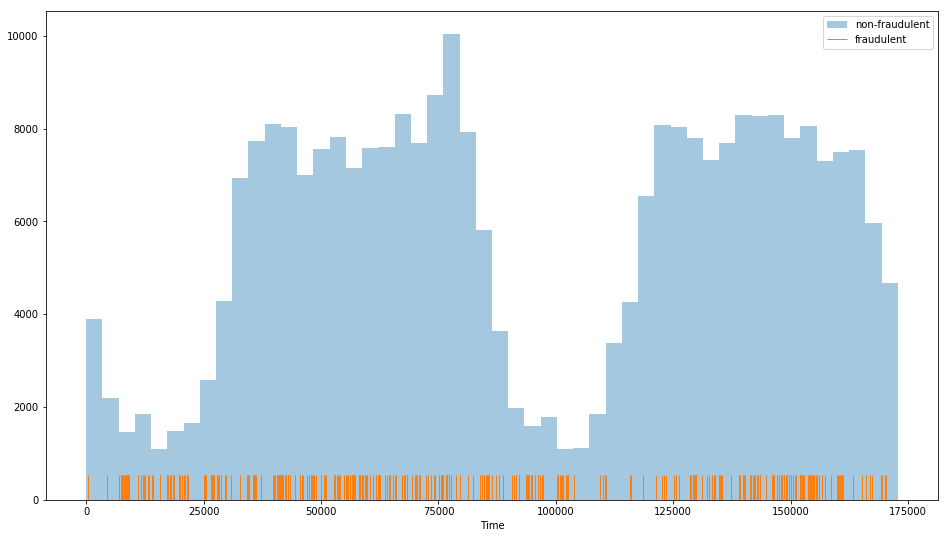

In [12]:
plt.figure(figsize=(16, 9))
sns.distplot(data_nf['Time'], kde=False, hist=True, label='non-fraudulent')
sns.distplot(data_f['Time'], kde=False, rug=True, hist=False, label='fraudulent')
plt.legend()
plt.show()


Options for time feature:

* treat as time series
* 


Distribution of 'Amount' feature


In [13]:
print('Summary of \'Amount\' for non-fraudulent transactions:\n\n{}'.format(data_nf['Amount'].describe()))
print('\n\nSummary of \'Amount\' for fraudulent transactions:\n\n{}'.format(data_f['Amount'].describe()))


Summary of 'Amount' for non-fraudulent transactions:

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Summary of 'Amount' for fraudulent transactions:

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


* Outliers are extremly high for both cases in relation to mean.
* fraudulent transactions tend to be of a lower amount than non-fraudulent transactions. 1/5th of 25% quantile, less
than half of mean.
* std for both cases is fairly close (250 vs 256), considering that fraudulent transactions tend to be of a lower amount.
This means, that 


Let's see what the percentage of outliers is.
  
  Define outliers as datapoints in 95'th percentile


In [14]:
data_f['Amount'].quantile(.95)

640.9049999999999

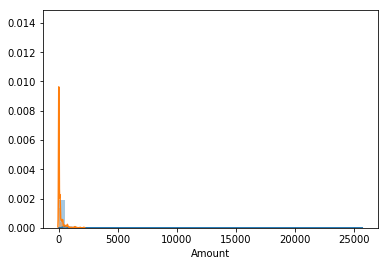

In [15]:
sns.distplot(data_nf['Amount'])
sns.distplot(data_f['Amount'])


Log amount

how many 0 value transactions


In [16]:
print('Zero value non-fraudulent transactions:\n{}\n{}% of all non-fraudulent transactions'.format(
    data_nf['Amount'].loc[data_nf['Amount']==0].count(),
    round(data_nf['Amount'].loc[data_nf['Amount']==0].count()/len(data_nf['Amount']), 4)
    ))
print('\nZero value fraudulent ransactions:\n{}\n{}% of all non-fraudulent transactions'.format(
    data_f['Amount'].loc[data_f['Amount']==0].count(),
    round(data_f['Amount'].loc[data_f['Amount']==0].count()/len(data_f['Amount']), 4)
    ))


Zero value non-fraudulent transactions:
1798
0.0063% of all non-fraudulent transactions

Zero value fraudulent ransactions:
27
0.0549% of all non-fraudulent transactions


Transactions with value of 0 are more likely to be fraudulent
* Could create seperate model for zero-vlaue transactions




C:\Anaconda\envs\Py\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


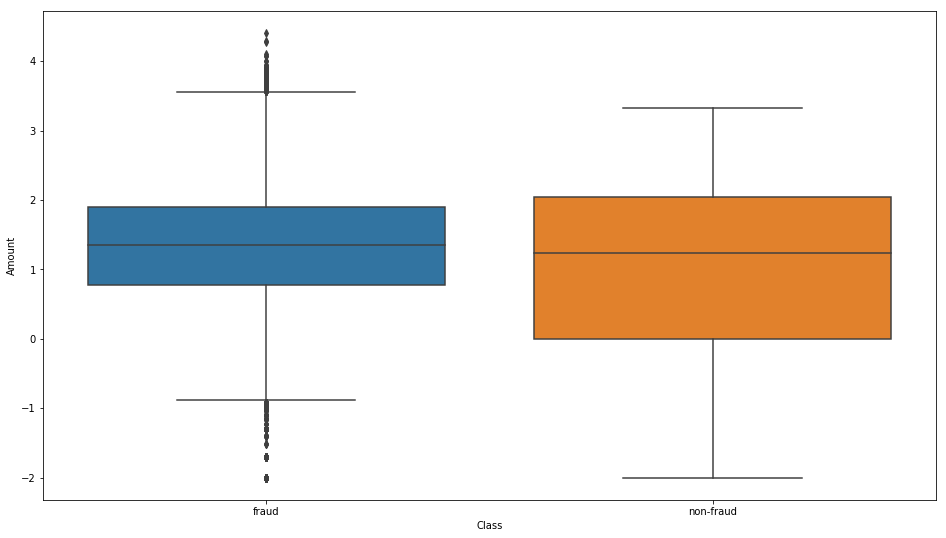

In [28]:
data_log = pd.DataFrame()
data_log['Amount'] = data['Amount'].replace(0, -1)

plt.figure(figsize=(16, 9))
sns.boxplot(y=np.log10(data_log['Amount']), x='Class', data=data)
plt.xticks(np.arange(0, 2), ('fraud', 'non-fraud'))
plt.show()

del(data_log)


skew for target and kurtosis for target T-SNE


t-distributed Stochastic Neighbor Embedding

In [18]:
data_var = data.drop(['Amount', 'Time'], axis=1)


<a id='section4'></a>
## Preprocessing


<a id='section4.1'></a>
